# Import and Install Required Libraries

In [79]:
# =====================================================
# Standard Library
# =====================================================
import os
import sys
import math
import gc
import random
import pickle
from pathlib import Path
from functools import partial
from pprint import pprint
from tqdm import tqdm

# =====================================================
# Third-Party Libraries
# =====================================================
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import joblib

# =====================================================
# TensorFlow / Keras
# =====================================================
import tensorflow as tf
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import layers, Model, Input, mixed_precision
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    Callback,    
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint
)

from tensorflow.keras.utils import to_categorical, custom_object_scope

# Enable XLA Compilation
tf.config.optimizer.set_jit(True)

# EfficientNetV2S fallback import
try:
    from tensorflow.keras.applications import EfficientNetV2S
except Exception:
    from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S

# =====================================================
# Scikit-Learn
# =====================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score
)
from sklearn.utils import class_weight
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# =====================================================
# Mixed Precision
# =====================================================
mixed_precision.set_global_policy("mixed_float16")


# =====================================================
# Train ML Models on GPU
# =====================================================
from cuml.linear_model import LogisticRegression
import cupy as cp


# Merge Cluster information with Metadata and Verify

In [6]:
# Load your original metadata and cluster results
df_meta = pd.read_csv('/kaggle/input/coral-metrics-and-clusters/metadata.csv')
df_clusters = pd.read_csv('/kaggle/input/coral-metrics-and-clusters/coral_clusters.csv')

# Merge cluster information with metadata
df_with_clusters = df_meta.merge(df_clusters, on='image_path', how='left')

In [7]:
# Verify the merge
print(f"Original metadata shape: {df_meta.shape}")
print(f"Cluster data shape: {df_clusters.shape}")
print(f"Merged data shape: {df_with_clusters.shape}")
print(f"Missing clusters: {df_with_clusters['cluster'].isna().sum()}")

# Display sample with clusters
print("\nSample data with clusters:")
display(df_with_clusters.sample(10))

Original metadata shape: (39044, 4)
Cluster data shape: (39044, 2)
Merged data shape: (39044, 5)
Missing clusters: 0

Sample data with clusters:


,image_path,filename,folder,source,cluster
6507,/kaggle/input/coral-condition-dataset/coral_im...,HWB_0029_12_20230926_0026_31.jpg,clipped,dry,4
17284,/kaggle/input/coral-condition-dataset/coral_im...,SKI_0004_00_20230817_0007_15.jpg,clipped,dry,0
3577,/kaggle/input/coral-condition-dataset/coral_im...,ALK_0030_11_20230927_0059_23.jpg,clipped,dry,2
16734,/kaggle/input/coral-condition-dataset/coral_im...,SKI_0004_00_20230817_0013_33.jpg,clipped,dry,2
21592,/kaggle/input/coral-condition-dataset/coral_im...,CBK_0001_00_20230804_0006_24.jpg,clipped,dry,4
1166,/kaggle/input/coral-condition-dataset/coral_im...,SWP_0025_00_20230919_0010_18.jpg,clipped,dry,2
6896,/kaggle/input/coral-condition-dataset/coral_im...,HWB_0029_12_20230926_0009_26.jpg,clipped,dry,0
9595,/kaggle/input/coral-condition-dataset/coral_im...,HWB_0029_12_20230926_0067_4.jpg,clipped,dry,0
18302,/kaggle/input/coral-condition-dataset/coral_im...,SKI_0004_00_20230817_0095_17.jpg,clipped,dry,2
24895,/kaggle/input/coral-condition-dataset/coral_im...,TCB_0003_00_20230816_0066_8.jpg,clipped,dry,4


In [8]:
# Check cluster distribution in the merged data
print("\nCluster distribution in merged data:")
df_with_clusters['cluster'].value_counts().sort_index()


Cluster distribution in merged data:


cluster
0     9379
1     2785
2    14780
3     5175
4     6925
Name: count, dtype: int64

In [9]:
# Save the enhanced dataset
df_with_clusters.to_csv('/kaggle/working/metadata_with_clusters.csv', index=False)
print(f"\nSaved enhanced dataset to: /kaggle/working/metadata_with_clusters.csv")


Saved enhanced dataset to: /kaggle/working/metadata_with_clusters.csv


In [10]:
df_with_clusters.info

<bound method DataFrame.info of                                               image_path  \
0      /kaggle/input/coral-condition-dataset/coral_im...   
1      /kaggle/input/coral-condition-dataset/coral_im...   
2      /kaggle/input/coral-condition-dataset/coral_im...   
3      /kaggle/input/coral-condition-dataset/coral_im...   
4      /kaggle/input/coral-condition-dataset/coral_im...   
...                                                  ...   
39039  /kaggle/input/coral-condition-dataset/coral_im...   
39040  /kaggle/input/coral-condition-dataset/coral_im...   
39041  /kaggle/input/coral-condition-dataset/coral_im...   
39042  /kaggle/input/coral-condition-dataset/coral_im...   
39043  /kaggle/input/coral-condition-dataset/coral_im...   

                               filename        folder source  cluster  
0         SWP_0025_00_20230919_0020.jpg  20230919_SWP    dry        2  
1         SWP_0025_00_20230919_0001.jpg  20230919_SWP    dry        2  
2         SWP_0025_00_20230919_

In [11]:
df_with_clusters.sample(25)

,image_path,filename,folder,source,cluster
23096,/kaggle/input/coral-condition-dataset/coral_im...,TCB_0003_00_20230816_0097_14.jpg,clipped,dry,1
9117,/kaggle/input/coral-condition-dataset/coral_im...,HWB_0029_12_20230926_0019_20.jpg,clipped,dry,2
16294,/kaggle/input/coral-condition-dataset/coral_im...,SKI_0004_00_20230817_0057_19.jpg,clipped,dry,4
20053,/kaggle/input/coral-condition-dataset/coral_im...,SKI_0004_00_20230817_0013_7.jpg,clipped,dry,2
33907,/kaggle/input/coral-condition-dataset/coral_im...,CBK_0038_00_20240124_0035_24.jpg,cropped,wet,2
22624,/kaggle/input/coral-condition-dataset/coral_im...,TCB_0003_00_20230816_0095_15.jpg,clipped,dry,1
22384,/kaggle/input/coral-condition-dataset/coral_im...,TCB_0003_00_20230816_0063.jpg,20230816_TCB,dry,2
11200,/kaggle/input/coral-condition-dataset/coral_im...,HNM_0031_00_20230928_0012_34.jpg,clipped,dry,3
160,/kaggle/input/coral-condition-dataset/coral_im...,SWP_0025_00_20230919_0037_24.jpg,clipped,dry,2
27921,/kaggle/input/coral-condition-dataset/coral_im...,HWB_0037_12_20240122_0066_15.jpg,cropped,wet,3


# Merge cluster metrics

In [12]:
# Add cluster color metrics information
metrics_df = pd.read_csv('/kaggle/input/coral-metrics-and-clusters/cluster_color_metrics.csv')

# Rename columns to distinguish cluster-level metrics
metrics_df_renamed = metrics_df.rename(columns={
    'mean_brightness': 'cluster_mean_brightness',
    'mean_saturation': 'cluster_mean_saturation', 
    'mean_luminance_std': 'cluster_mean_luminance_std'
}).drop('n_images', axis=1)  # Drop n_images as it's redundant

# Merge cluster metrics
df_complete = df_with_clusters.merge(metrics_df_renamed, on='cluster', how='left')

In [13]:
print(f"Complete dataset shape: {df_complete.shape}")
print("\nColumns in complete dataset:")
df_complete.columns.tolist()

Complete dataset shape: (39044, 8)

Columns in complete dataset:


['image_path',
 'filename',
 'folder',
 'source',
 'cluster',
 'cluster_mean_brightness',
 'cluster_mean_saturation',
 'cluster_mean_luminance_std']

In [14]:
# Save the complete analysis dataset
df_complete.to_csv('/kaggle/working/coral_dataset_with_clusters_and_metrics.csv', index=False)
print(f"\nSaved complete dataset to: /kaggle/working/coral_dataset_with_clusters_and_metrics.csv")


Saved complete dataset to: /kaggle/working/coral_dataset_with_clusters_and_metrics.csv


In [15]:
df_complete.sample(25)

,image_path,filename,folder,source,cluster,cluster_mean_brightness,cluster_mean_saturation,cluster_mean_luminance_std
26946,/kaggle/input/coral-condition-dataset/coral_im...,HWB_0037_12_20240122_0021_21.jpg,cropped,wet,4,0.498285,0.275200,0.147476
31124,/kaggle/input/coral-condition-dataset/coral_im...,ALK_0035_00_20240118_0017_21.jpg,cropped,wet,2,0.346147,0.331251,0.143388
38084,/kaggle/input/coral-condition-dataset/coral_im...,SKI_0033_00_20240103_0012.jpg,20240103_SKI_done,wet,2,0.346147,0.331251,0.143388
6686,/kaggle/input/coral-condition-dataset/coral_im...,HWB_0029_12_20230926_0084_12.jpg,clipped,dry,0,0.213652,0.430153,0.107641
9550,/kaggle/input/coral-condition-dataset/coral_im...,HWB_0029_12_20230926_0035_26.jpg,clipped,dry,4,0.498285,0.275200,0.147476
7680,/kaggle/input/coral-condition-dataset/coral_im...,HWB_0029_12_20230926_0058_18.jpg,clipped,dry,2,0.346147,0.331251,0.143388
28434,/kaggle/input/coral-condition-dataset/coral_im...,HWB_0037_12_20240122_0071_27.jpg,cropped,wet,0,0.213652,0.430153,0.107641
26935,/kaggle/input/coral-condition-dataset/coral_im...,HWB_0037_12_20240122_0043_18.jpg,cropped,wet,2,0.346147,0.331251,0.143388
38736,/kaggle/input/coral-condition-dataset/coral_im...,SKI_0033_00_20240103_0013_13.jpg,cropped,wet,4,0.498285,0.275200,0.147476
19156,/kaggle/input/coral-condition-dataset/coral_im...,SKI_0004_00_20230817_0080_13.jpg,clipped,dry,2,0.346147,0.331251,0.143388


# Cross-tabulation: clusters vs sources

In [16]:
# Cross-tabulation: clusters vs sources
cluster_source_ct = pd.crosstab(df_with_clusters['cluster'], df_with_clusters['source'])
print("Cluster distribution across dry/wet sources:")
cluster_source_ct

Cluster distribution across dry/wet sources:


source,dry,wet
cluster,,
0,5704,3675
1,1888,897
2,9744,5036
3,4423,752
4,4541,2384


# Cross-tabulation: clusters vs folders

In [17]:
cluster_folder_ct = pd.crosstab(df_with_clusters['cluster'], df_with_clusters['folder'])
print("\nTop folders in each cluster (showing top 5 folders per cluster):")
for cluster_id in sorted(df_with_clusters['cluster'].unique()):
    cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
    top_folders = cluster_data['folder'].value_counts().head(5)
    print(f"\nCluster {cluster_id}:")
    for folder, count in top_folders.items():
        print(f"  {folder}: {count} images")


Top folders in each cluster (showing top 5 folders per cluster):

Cluster 0:
  clipped: 5694 images
  cropped: 3655 images
  20240118_ALK_done: 8 images
  20240126_CBK_done: 6 images
  20230926_HWB: 4 images

Cluster 1:
  clipped: 1877 images
  cropped: 895 images
  20230804_CBK: 11 images
  20240119_SKI_done: 1 images
  20240103_SKI_done: 1 images

Cluster 2:
  clipped: 9251 images
  cropped: 4751 images
  20230817_SKI: 101 images
  20230926_HWB: 100 images
  20230816_TCB: 99 images

Cluster 3:
  clipped: 4299 images
  cropped: 738 images
  20230927_ALK: 29 images
  20230928_HNM: 24 images
  20230421_preliminary_survey: 22 images

Cluster 4:
  clipped: 4425 images
  cropped: 2351 images
  20230804_CBK: 59 images
  20230817_SKI: 36 images
  20240103_SKI_done: 15 images


<Figure size 1000x600 with 0 Axes>

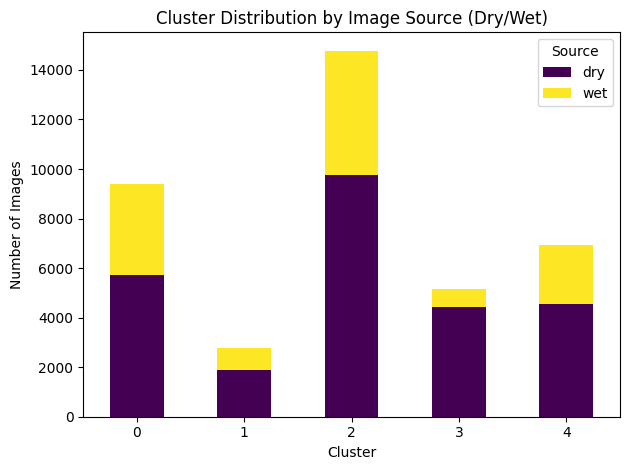

In [18]:
# Visualization: Cluster distribution by source
plt.figure(figsize=(10, 6))
cluster_source_ct.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Cluster Distribution by Image Source (Dry/Wet)')
plt.xlabel('Cluster')
plt.ylabel('Number of Images')
plt.legend(title='Source')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('/kaggle/working/cluster_distribution_by_source.png', dpi=200)
plt.show()

# Data Preparation and Splitting

In [19]:
# Prepare data
X = np.load('/kaggle/input/coral-metrics-and-clusters/coral_features.npy')  
df_complete = pd.read_csv('/kaggle/working/coral_dataset_with_clusters_and_metrics.csv')

# Use clusters as labels (since you want to predict/validate clusters)
y = df_complete['cluster'].values

# Split data - stratify to maintain cluster distribution
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Convert labels to categorical for neural network
num_classes = len(np.unique(y))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

Training set: 27330 samples
Validation set: 5857 samples
Test set: 5857 samples


# Build a Simple Neural Network Classifier

In [20]:
def create_simple_nn_model(input_dim, num_classes):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(64, activation='relu'),
        Dropout(0.2),
        
        Dense(num_classes, activation='softmax')
    ])
    
    return model

In [21]:
# Create model
model = create_simple_nn_model(X.shape[1], num_classes)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1763861220.951818      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763861220.952610      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 832,261 (3.17 MB)

 Trainable params: 830,469 (3.17 MB)

 Non-trainable params: 1,792 (7.00 KB)

# Train with Callbacks for Efficient GPU Usage

In [22]:
# Callbacks to prevent overfitting and optimize training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        '/kaggle/working/simple_nn_classifier.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

In [23]:
# Train the model
history = model.fit(
    X_train, y_train_cat,
    batch_size=128,  # Adjust based on GPU memory
    epochs=100,
    validation_data=(X_val, y_val_cat),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


I0000 00:00:1763861225.083611     122 service.cc:148] XLA service 0x7b85680074a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763861225.085052     122 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763861225.085071     122 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763861225.147231     122 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763861225.288806     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3159 - loss: 1.5968

214/214 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.3164 - loss: 1.5962 - val_accuracy: 0.3785 - val_loss: 1.4988 - learning_rate: 0.0010
Epoch 2/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5154 - loss: 1.2922 - val_accuracy: 0.3765 - val_loss: 1.5079 - learning_rate: 0.0010
Epoch 3/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5445 - loss: 1.2418 - val_accuracy: 0.3348 - val_loss: 1.4166 - learning_rate: 0.0010
Epoch 4/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5548 - loss: 1.2231 - val_accuracy: 0.2566 - val_loss: 1.6214 - learning_rate: 0.0010
Epoch 5/100
206/214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5542 - loss: 1.2211

214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5545 - loss: 1.2209 - val_accuracy: 0.3935 - val_loss: 2.1431 - learning_rate: 0.0010
Epoch 6/100
204/214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5711 - loss: 1.2021

214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5708 - loss: 1.2022 - val_accuracy: 0.4439 - val_loss: 1.5558 - learning_rate: 0.0010
Epoch 7/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5725 - loss: 1.1940 - val_accuracy: 0.2290 - val_loss: 1.5583 - learning_rate: 0.0010
Epoch 8/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5652 - loss: 1.2117 - val_accuracy: 0.3483 - val_loss: 1.3937 - learning_rate: 0.0010
Epoch 9/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5770 - loss: 1.1926 - val_accuracy: 0.2691 - val_loss: 1.5440 - learning_rate: 0.0010
Epoch 10/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5749 - loss: 1.1969 - val_accuracy: 0.1059 - val_loss: 1.8392 - learning_rate: 0.0010
Epoch 11/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5802 - loss: 1.1857 - val_accuracy: 0.3550 - val_loss: 1.4103 - learning_rate: 0.0010
Epoch 12/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5702 - loss: 1.2028 - va

214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5800 - loss: 1.1837 - val_accuracy: 0.4762 - val_loss: 1.3186 - learning_rate: 5.0000e-04
Epoch 15/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5786 - loss: 1.1852 - val_accuracy: 0.3222 - val_loss: 1.4703 - learning_rate: 5.0000e-04
Epoch 16/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5851 - loss: 1.1813 - val_accuracy: 0.4458 - val_loss: 1.3346 - learning_rate: 5.0000e-04
Epoch 17/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5858 - loss: 1.1773 - val_accuracy: 0.2040 - val_loss: 1.6585 - learning_rate: 5.0000e-04
Epoch 18/100
205/214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5795 - loss: 1.1861

214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5796 - loss: 1.1859 - val_accuracy: 0.5155 - val_loss: 1.2298 - learning_rate: 5.0000e-04
Epoch 19/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5876 - loss: 1.1731 - val_accuracy: 0.3486 - val_loss: 1.4320 - learning_rate: 5.0000e-04
Epoch 20/100
203/214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5820 - loss: 1.1800

214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5819 - loss: 1.1803 - val_accuracy: 0.5419 - val_loss: 1.2123 - learning_rate: 5.0000e-04
Epoch 21/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5788 - loss: 1.1834 - val_accuracy: 0.4832 - val_loss: 1.3342 - learning_rate: 5.0000e-04
Epoch 22/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5878 - loss: 1.1811 - val_accuracy: 0.3893 - val_loss: 1.4068 - learning_rate: 5.0000e-04
Epoch 23/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5850 - loss: 1.1854 - val_accuracy: 0.5242 - val_loss: 1.2324 - learning_rate: 5.0000e-04
Epoch 24/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5886 - loss: 1.1736 - val_accuracy: 0.4400 - val_loss: 1.4004 - learning_rate: 5.0000e-04
Epoch 25/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5859 - loss: 1.1725 - val_accuracy: 0.3620 - val_loss: 1.5085 - learning_rate: 5.0000e-04
Epoch 26/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy:

214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5854 - loss: 1.1681 - val_accuracy: 0.5542 - val_loss: 1.2031 - learning_rate: 2.5000e-04
Epoch 30/100
205/214 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5848 - loss: 1.1785

214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5849 - loss: 1.1784 - val_accuracy: 0.6104 - val_loss: 1.1583 - learning_rate: 2.5000e-04
Epoch 31/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5857 - loss: 1.1730 - val_accuracy: 0.5977 - val_loss: 1.1598 - learning_rate: 2.5000e-04
Epoch 32/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5868 - loss: 1.1758 - val_accuracy: 0.4605 - val_loss: 1.2976 - learning_rate: 2.5000e-04
Epoch 33/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5885 - loss: 1.1702 - val_accuracy: 0.4195 - val_loss: 1.3751 - learning_rate: 2.5000e-04
Epoch 34/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5856 - loss: 1.1731 - val_accuracy: 0.4420 - val_loss: 1.3492 - learning_rate: 2.5000e-04
Epoch 35/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5833 - loss: 1.1795 - val_accuracy: 0.5498 - val_loss: 1.2213 - learning_rate: 2.5000e-04
Epoch 36/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy:

# Comprehensive Model Evaluation

In [24]:
# Load the Simple NN Classifier trained model
model.load_weights('/kaggle/working/simple_nn_classifier.h5')

# Predictions
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [25]:
# Classification Report
print("Classification Report of Simple NN Model:")
print(classification_report(y_test, y_pred))

Classification Report of Simple NN Model:
              precision    recall  f1-score   support

           0       0.59      0.60      0.59      1407
           1       0.50      0.55      0.52       418
           2       0.66      0.69      0.68      2217
           3       0.61      0.54      0.57       776
           4       0.59      0.54      0.57      1039

    accuracy                           0.61      5857
   macro avg       0.59      0.58      0.59      5857
weighted avg       0.61      0.61      0.61      5857



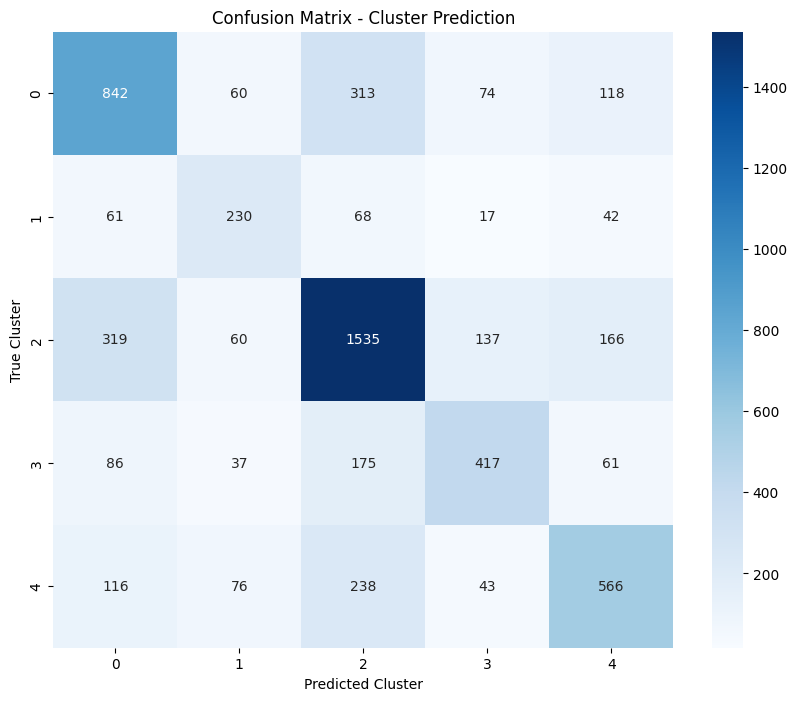

In [26]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Cluster Prediction')
plt.ylabel('True Cluster')
plt.xlabel('Predicted Cluster')
plt.savefig('/kaggle/working/confusion_matrix.png', dpi=200)
plt.show()

# Load the Previous Pipeline Outputs obtained from the Actual Data

In [28]:
# ----------------------------
# Robust pipeline using your existing outputs
# - Uses precomputed features + cluster labels as targets when no human labels exist
# - Trains: (A) Feature-based classifier (fast) (B) Image-based fine-tuned EfficientNetV2-S (strong)
# - Saves artifacts to /kaggle/working/
# ----------------------------
# ---- Paths (these are the outputs you saved earlier) ----
WORK = Path("/kaggle/working")
INPUT = Path("/kaggle/input/coral-metrics-and-clusters")
features_fp = INPUT / "coral_features.npy"
valid_paths_fp = INPUT / "valid_paths.csv"
clusters_fp = INPUT / "coral_clusters.csv"
metadata_fp = INPUT / "metadata.csv"
cluster_metrics_fp = INPUT / "cluster_color_metrics.csv"
tsne_fp = INPUT / "tsne_results.npy"

# Check files presence
for p in [features_fp, valid_paths_fp, clusters_fp]:
    if not p.exists():
        raise FileNotFoundError(f"Required file not found: {p}. This script expects the files you produced earlier.")

print("Found required outputs.")

Found required outputs.


In [29]:
# Load
features = np.load(str(features_fp))
valid_paths = pd.read_csv(str(valid_paths_fp))['image_path'].tolist()
df_clusters = pd.read_csv(str(clusters_fp))

print("Features shape:", features.shape)
print("Valid paths len:", len(valid_paths))
print("Clusters shape:", df_clusters.shape)

Features shape: (39044, 1280)
Valid paths len: 39044
Clusters shape: (39044, 2)


In [30]:
# Map: image_path -> cluster label
df_clusters_map = df_clusters.set_index('image_path')['cluster'].to_dict()
# Build dataset aligned to features list
aligned_labels = []
aligned_paths = []
for p in valid_paths:
    if p in df_clusters_map:
        aligned_labels.append(int(df_clusters_map[p]))
        aligned_paths.append(p)
    else:
        # fallback: skip if missing
        aligned_labels.append(-1)
        aligned_paths.append(p)
aligned_labels = np.array(aligned_labels)
# Remove any -1 entries (shouldn't happen given your earlier pipeline)
keep_mask = aligned_labels >= 0
features = features[keep_mask]
aligned_labels = aligned_labels[keep_mask]
aligned_paths = [p for i,p in enumerate(aligned_paths) if keep_mask[i]]

print("Aligned features:", features.shape, "Aligned labels:", aligned_labels.shape)

Aligned features: (39044, 1280) Aligned labels: (39044,)


In [31]:
# Quick stats
n_classes = int(aligned_labels.max()) + 1
print("Pseudo-targets: clustering yielded", n_classes, "classes.")
print(pd.Series(aligned_labels).value_counts().sort_index())

Pseudo-targets: clustering yielded 5 classes.
0     9379
1     2785
2    14780
3     5175
4     6925
Name: count, dtype: int64


# Baseline Traditional ML Model Training and Evaluation (Logistic Regression using GPU)

In [92]:
# ----------------------------
# 1) Baseline: Feature-based classifier (fast, strong)
# We'll train a simple pipeline (StandardScaler + LogisticRegression)
# ----------------------------
print("\n=== TRAIN: Feature-based classifier ===")
X = features
y = aligned_labels


=== TRAIN: Feature-based classifier ===


In [33]:
# split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.18, random_state=42, stratify=y)

In [34]:
# Scale
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)

In [43]:
# Move data to GPU
X_train_gpu = cp.asarray(X_train_s)
y_train_gpu = cp.asarray(y_train)

MAX_ITERS = 1000

print("Training LogisticRegression on GPU with single progress bar...")

# Progress bar (time-based approximation)
pbar = tqdm(total=MAX_ITERS, desc="GPU Logistic Regression", unit="iter")

# Start fit in background
model = LogisticRegression(max_iter=MAX_ITERS)
model.fit(X_train_gpu, y_train_gpu)

# Update the bar to 100%
pbar.update(MAX_ITERS)
pbar.close()

Training LogisticRegression on GPU with single progress bar...



GPU Logistic Regression:   0%|          | 0/1000 [00:14<?, ?iter/s]

GPU Logistic Regression: 100%|██████████| 1000/1000 [00:02<00:00, 338.63iter/s]

[2025-11-23 01:34:48.164] [CUML] [warning] L-BFGS: max iterations reached
[2025-11-23 01:34:48.165] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


In [46]:
# --------------------------
# Validation Predictions (GPU -> CPU)
# --------------------------
X_val_gpu = cp.asarray(X_val_s)
y_pred_gpu = model.predict(X_val_gpu)
yv_lr = cp.asnumpy(y_pred_gpu)

# --------------------------
# Metrics
# --------------------------
print("LR val acc:", accuracy_score(y_val, yv_lr))
print("macro F1:", f1_score(y_val, yv_lr, average='macro'))

print("\nLogistic Regression Classification Report:")
print(classification_report(y_val, yv_lr))

LR val acc: 0.9883323847467274
macro F1: 0.9855681895094073

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1688
           1       0.98      0.98      0.98       501
           2       0.99      0.99      0.99      2660
           3       0.98      0.98      0.98       932
           4       0.99      0.98      0.99      1247

    accuracy                           0.99      7028
   macro avg       0.99      0.98      0.99      7028
weighted avg       0.99      0.99      0.99      7028



In [47]:
# Save baseline
joblib.dump(
    {
        'scaler': scaler,
        'model_params': model.get_params()
    },
    WORK / "feature_logreg_pipeline.joblib"
)

print("Saved scaler and logistic regression params.")

Saved scaler and logistic regression params.


# Image-based EfficientNetV2-S Model Training, Finetuning and Evaluation

In [48]:
# ----------------------------
# Strong image-based model (EfficientNetV2-S -> train to predict clusters)
# Use cluster labels as pseudo-targets so you obtain an image model ready for later re-training with true labels
# ----------------------------
print("\n=== TRAIN: Image-based EfficientNetV2-S (predicting cluster IDs as targets) ===")

# prepare labels in one-hot for categorical crossentropy
y_onehot = to_categorical(aligned_labels, num_classes=n_classes)

# train/val split aligned with features -> reuse indices
# We'll compute indices from aligned_paths; create map of path->index for train_test_split earlier
# Simple way: resplit using the same seed and stratify:
# train/val split
train_idx, val_idx = train_test_split(
    range(len(aligned_paths)),
    test_size=0.18,
    random_state=42,
    stratify=aligned_labels
)
train_paths = [aligned_paths[i] for i in train_idx]
val_paths = [aligned_paths[i] for i in val_idx]
y_train = y_onehot[train_idx]
y_val = y_onehot[val_idx]

print("Train images:", len(train_paths), "Val images:", len(val_paths))


=== TRAIN: Image-based EfficientNetV2-S (predicting cluster IDs as targets) ===
Train images: 32016 Val images: 7028


# Pipeline Preparation for Image Model Training

In [61]:
# ----------------------------
# Dataset pipeline
# ----------------------------
IMG_SIZE = 384
BATCH = 24
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_image(path, label, training=True):
    # pure TF ops
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    if training:
        # First resize to >= IMG_SIZE
        img = tf.image.resize(img, [IMG_SIZE + 20, IMG_SIZE + 20])

        # Now safe to crop
        img = tf.image.random_crop(img, [IMG_SIZE, IMG_SIZE, 3])

        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, 0.08)
        img = tf.image.random_contrast(img, 0.9, 1.1)
    else:
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

    # EfficientNet scaling
    img = (img - 0.5) * 2.0
    
    # Ensure float32
    label = tf.cast(label, tf.float32)

    return img, label

In [62]:
def make_ds(paths, labels, training=True, batch=BATCH):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(4096)

    ds = ds.map(
        lambda p, l: preprocess_image(p, l, training),
        num_parallel_calls=AUTOTUNE
    )

    # ds = ds.batch(batch).prefetch(AUTOTUNE)
    ds = ds.batch(batch)
    ds = ds.prefetch(AUTOTUNE)
    return ds

In [63]:
train_ds = make_ds(train_paths, y_train, training=True)
val_ds   = make_ds(val_paths,  y_val, training=False)

# Build EfficientnetV2S Model, Freeze backbone, Train Head and Evaluation

In [64]:
def build_image_model(num_classes):
    inp = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='image')
    base = EfficientNetV2S(include_top=False, weights='imagenet', input_tensor=inp, pooling='avg')
    x = base.output
    x = layers.Dropout(0.35)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.25)(x)
    out = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    model = Model(inp, out)
    return model


img_model = build_image_model(n_classes)
img_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 384, 384,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 384, 384,  │          0 │ image[0][0]       │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 192, 192,  │        648 │ rescaling[0][0]   │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 192, 192,  │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 192, 192,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 192, 192,  │      5,184 │ stem_activation[… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 192, 192,  │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 192, 192,  │          0 │ block1a_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 192, 192,  │          0 │ block1a_project_… │
│                     │ 24)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 192, 192,  │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 192, 192,  │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 192, 192,  │          0 │ block1b_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 192, 192,  │          0 │ block1b_project_… │
│ (Dropout)           │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 192, 192,  │          0 │ block1b_drop[0][… │
│                     │ 24)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 96, 96,    │     20,736 │ block1b_add[0][0] │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 96, 96,    │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 96, 96,    │          0 │ block2a_expand_b

 Total params: 20,991,845 (80.08 MB)

 Trainable params: 20,836,949 (79.49 MB)

 Non-trainable params: 154,896 (605.06 KB)

In [65]:
# compile
try:
    opt = AdamW(learning_rate=1e-3, weight_decay=1e-5)
except:
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

img_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
# callbacks
ckpdir = WORK / "img_model_ckpt"
ckpdir.mkdir(parents=True, exist_ok=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(str(ckpdir/"best_img_model.h5"), monitor='val_accuracy', save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, min_lr=1e-6)
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

In [67]:
# ----------------------------
# Correct Freezing
# ----------------------------
# Freeze ONLY the EfficientNetV2 backbone
for layer in img_model.layers:
    if isinstance(layer, tf.keras.Model):   # this is your backbone
        layer.trainable = False

# Confirm trainable layers > 0
print("\nTrainable layers:", len([l for l in img_model.layers if l.trainable]))


Trainable layers: 519


In [69]:
# ----------------------------
# Train head (backbone frozen)
# ----------------------------
with tf.device('/GPU:0'):
    img_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=6,
        callbacks=[checkpoint, reduce_lr, es],
        verbose=1
    )

Epoch 1/6


Training:   0%|          | 0/6 [10:08<?, ?epoch/s]


 109/1334 ━━━━━━━━━━━━━━━━━━━━ 11:10 547ms/step - accuracy: 0.4604 - loss: 1.80537, change: 0.00048548
Epoch 688, change: 0.00048467
Epoch 689, change: 0.00057171
Epoch 690, change: 0.00054990
Epoch 691, change: 0.00049963
Epoch 692, change: 0.00047757
Epoch 693, change: 0.00047706
Epoch 694, change: 0.00048026
Epoch 695, change: 0.00049388
Epoch 696, change: 0.00047755
Epoch 697, change: 0.00050943
Epoch 698, change: 0.00061429
Epoch 699, change: 0.00059540
Epoch 700, change: 0.00058166
Epoch 701, change: 0.00055285
Epoch 702, change: 0.00059817
Epoch 703, change: 0.00058357
Epoch 704, change: 0.00053986
Epoch 705, change: 0.00056116
Epoch 706, change: 0.00068714
Epoch 707, change: 0.00058157
Epoch 708, change: 0.00054707
Epoch 709, change: 0.00057102
Epoch 710, change: 0.00062779
Epoch 711, change: 0.00059379
Epoch 712, change: 0.00053080
Epoch 713, change: 0.00047713
Epoch 714, change: 0.00047919
Epoch 715, change: 0.00067189
Epoch 716, change: 0.00047746
Epoch 717, change: 0.000661

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


1334/1334 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.6167 - loss: 1.0776

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 1032s 657ms/step - accuracy: 0.6167 - loss: 1.0774 - val_accuracy: 0.1917 - val_loss: 4.0015 - learning_rate: 0.0010
Epoch 2/6
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.6818 - loss: 0.7810

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 863s 647ms/step - accuracy: 0.6819 - loss: 0.7810 - val_accuracy: 0.6659 - val_loss: 0.8579 - learning_rate: 0.0010
Epoch 3/6
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 860s 645ms/step - accuracy: 0.7274 - loss: 0.6480 - val_accuracy: 0.4152 - val_loss: 1.4921 - learning_rate: 0.0010
Epoch 4/6
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 860s 644ms/step - accuracy: 0.7567 - loss: 0.5955 - val_accuracy: 0.2255 - val_loss: 2.5155 - learning_rate: 0.0010
Epoch 5/6
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 872s 653ms/step - accuracy: 0.7749 - loss: 0.5375 - val_accuracy: 0.1844 - val_loss: 2.6119 - learning_rate: 5.0000e-04
Epoch 6/6
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.7959 - loss: 0.4917

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 866s 649ms/step - accuracy: 0.7959 - loss: 0.4917 - val_accuracy: 0.7002 - val_loss: 1.0330 - learning_rate: 5.0000e-04


# Unfreeze, Finetune and Evaluate the EfficientnetV2S backbone

In [70]:
# Unfreeze and fine-tune
print("\nUnfreezing backbone for fine-tuning...")
for layer in img_model.layers:
    layer.trainable = True

# recompile with lower LR
try:
    opt2 = AdamW(learning_rate=5e-5, weight_decay=1e-6)
except Exception:
    opt2 = tf.keras.optimizers.Adam(learning_rate=5e-5)
img_model.compile(optimizer=opt2, loss='categorical_crossentropy', metrics=['accuracy'])

print("\nFine-tuning backbone...")
img_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=12,
    callbacks=[checkpoint, reduce_lr, es, TQDMProgressBar()],
    verbose=0
)


Unfreezing backbone for fine-tuning...

Fine-tuning backbone...


Training: 100%|██████████| 12/12 [2:54:55<00:00, 874.64s/epoch, loss=0.3159, acc=0.8683, val_acc=0.8715]


In [71]:
custom_objs = {
    "Cast": tf.cast  # register Cast op for loading
}

# Load best saved img model if exists
best_img = ckpdir / "best_img_model.h5"

if best_img.exists():
    with custom_object_scope(custom_objs):
        img_model = tf.keras.models.load_model(str(best_img))
    print("Loaded best image model from checkpoint.")

Loaded best image model from checkpoint.


In [76]:
# Evaluate on val set
print("\nEvaluating image model on validation set:")
val_preds = img_model.predict(val_ds)
val_pred_labels = val_preds.argmax(axis=1)
y_val_labels = y_val.argmax(axis=1)
print("\nAccuracy:", accuracy_score(y_val_labels, val_pred_labels))
print("Macro F1:", f1_score(y_val_labels, val_pred_labels, average='macro'))
print("\nClassification Report: ", classification_report(y_val_labels, val_pred_labels))


Evaluating image model on validation set:
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 160ms/step

Accuracy: 0.8998292544109278
Macro F1: 0.8923051186181343

Classification Report:                precision    recall  f1-score   support

           0       0.95      0.92      0.93      1688
           1       0.93      0.86      0.90       501
           2       0.89      0.94      0.91      2660
           3       0.90      0.82      0.86       932
           4       0.85      0.88      0.86      1247

    accuracy                           0.90      7028
   macro avg       0.90      0.88      0.89      7028
weighted avg       0.90      0.90      0.90      7028



In [77]:
# Save final image model
img_out = WORK / "efficientnetv2s_coral_clusters.keras"
img_model.save(img_out, include_optimizer=False)
print("Saved image model to:", img_out)

Saved image model to: /kaggle/working/efficientnetv2s_coral_clusters.keras


# Save Overall Model Training Results

In [84]:
# ----------------------------
# Save metadata and full report (all metrics)
# ----------------------------

# Convert one-hot validation labels → integer labels
y_val_int = np.argmax(y_val, axis=1)

# Logistic regression accuracy (already computed earlier)
if 'yv_lr' in locals():
    feature_lr_acc = float(accuracy_score(y_val_int, yv_lr))
else:
    feature_lr_acc = None

# ----------------------------
# Image model metrics
# ----------------------------
val_acc         = accuracy_score(y_val_labels, val_pred_labels)
macro_f1        = f1_score(y_val_labels, val_pred_labels, average='macro')
weighted_f1     = f1_score(y_val_labels, val_pred_labels, average='weighted')
macro_prec      = precision_score(y_val_labels, val_pred_labels, average='macro')
weighted_prec   = precision_score(y_val_labels, val_pred_labels, average='weighted')
macro_recall    = recall_score(y_val_labels, val_pred_labels, average='macro')
weighted_recall = recall_score(y_val_labels, val_pred_labels, average='weighted')

# Confusion matrix + full classification report
cm = confusion_matrix(y_val_labels, val_pred_labels)
cls_report = classification_report(y_val_labels, val_pred_labels, output_dict=True)

# ----------------------------
# Final JSON-compatible report
# ----------------------------
report = {
    "n_samples": int(len(aligned_paths)),
    "n_classes (clusters)": int(n_classes),

    # Feature-based LR (GPU cuML)
    "feature_model_lr_acc": feature_lr_acc,

    # Image model metrics
    "image_model_val_acc": float(val_acc),
    "image_model_macro_f1": float(macro_f1),
    "image_model_weighted_f1": float(weighted_f1),
    "image_model_macro_precision": float(macro_prec),
    "image_model_weighted_precision": float(weighted_prec),
    "image_model_macro_recall": float(macro_recall),
    "image_model_weighted_recall": float(weighted_recall),

    # Raw outputs
    "confusion_matrix": cm.tolist(),
    "classification_report": cls_report
}

# Save summary CSV
pd.Series(report).to_csv(WORK / "efficientnetv2s_training_report_summary.csv")
print("\nSaved summary to efficientnetv2s_training_report_summary.csv")
print("\nReport:")
report


Saved summary to efficientnetv2s_training_report_summary.csv

Report:


{'n_samples': 39044,
 'n_classes (clusters)': 5,
 'feature_model_lr_acc': 0.9883323847467274,
 'image_model_val_acc': 0.8998292544109278,
 'image_model_macro_f1': 0.8923051186181343,
 'image_model_weighted_f1': 0.8997202623294729,
 'image_model_macro_precision': 0.9044900627324332,
 'image_model_weighted_precision': 0.9011804019446629,
 'image_model_macro_recall': 0.8820135196662019,
 'image_model_weighted_recall': 0.8998292544109278,
 'confusion_matrix': [[1546, 0, 142, 0, 0],
  [0, 433, 0, 14, 54],
  [73, 0, 2490, 31, 66],
  [0, 10, 87, 761, 74],
  [0, 23, 94, 36, 1094]],
 'classification_report': {'0': {'precision': 0.9549104385423101,
   'recall': 0.9158767772511849,
   'f1-score': 0.934986392500756,
   'support': 1688},
  '1': {'precision': 0.9291845493562232,
   'recall': 0.8642714570858283,
   'f1-score': 0.8955532574974147,
   'support': 501},
  '2': {'precision': 0.8851759687166726,
   'recall': 0.9360902255639098,
   'f1-score': 0.9099214324867532,
   'support': 2660},
  '3':

# Download the Captured Results

In [87]:
!pwd

/kaggle/working


In [88]:
!zip -r modeling_results.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/cluster_distribution_by_source.png (deflated 20%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/efficientnetv2s_coral_clusters.keras (deflated 9%)
  adding: kaggle/working/metadata_with_clusters.csv (deflated 95%)
  adding: kaggle/working/feature_logreg_pipeline.joblib (deflated 4%)
  adding: kaggle/working/simple_nn_classifier.h5 (deflated 22%)
  adding: kaggle/working/confusion_matrix.png (deflated 21%)
  adding: kaggle/working/efficientnetv2s_training_report_summary.csv (deflated 60%)
  adding: kaggle/working/coral_dataset_with_clusters_and_metrics.csv (deflated 96%)
  adding: kaggle/working/img_model_ckpt/ (stored 0%)
  adding: kaggle/working/img_model_ckpt/best_img_model.h5 (deflated 7%)


In [89]:
!ls -lrth

total 414M
-rw-r--r-- 1 root root 6.4M Nov 23 01:26 metadata_with_clusters.csv
-rw-r--r-- 1 root root 8.5M Nov 23 01:26 coral_dataset_with_clusters_and_metrics.csv
-rw-r--r-- 1 root root  57K Nov 23 01:26 cluster_distribution_by_source.png
-rw-r--r-- 1 root root 9.6M Nov 23 01:27 simple_nn_classifier.h5
-rw-r--r-- 1 root root  89K Nov 23 01:27 confusion_matrix.png
-rw-r--r-- 1 root root  31K Nov 23 01:38 feature_logreg_pipeline.joblib
drwxr-xr-x 2 root root 4.0K Nov 23 02:06 img_model_ckpt
-rw-r--r-- 1 root root  82M Nov 23 06:18 efficientnetv2s_coral_clusters.keras
-rw-r--r-- 1 root root 1.4K Nov 23 06:22 efficientnetv2s_training_report_summary.csv
-rw-r--r-- 1 root root 307M Nov 23 06:25 modeling_results.zip


In [91]:
from IPython.display import FileLink
FileLink(r'modeling_results.zip')

/kaggle/working/modeling_results.zip